Last updated: 27 Jul 2018

# Exploring US Endangered Species Data with Python

This notebook retrieves data from the US Fish & Wildlife Service on endangered and threatened species listed under the Endangered Species Act. It runs a simple analysis and returns a graph of species added under the ESA over time.

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup 
import pandas as pd
import re, requests
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [16, 8]

## Data source

Data are retrieved from the U.S. Fish & Wildlife Service [Environmental Conservation Online System](https://ecos.fws.gov/ecp/), which reports on Threatened & Endangered species in the United States that are protected by the Endangered Species Act (ESA). 

There are a number of different reports are available here: https://ecos.fws.gov/ecp/species-reports. They are mostly provided as sortable tables, viewable online.

## What question are we asking?

After looking at some of the available datasets, it seems like there are data available on how many requests were made to list species, and how many species were officially listed.

For the purposes of this analysis, let's ask the following question:

> *How has the rate of species being listed under the ESA changed over time?*

## Downloading listing years

We can use the `requests` and `BeautifulSoup` libraries to scrape the [U.S. Federal Endangered and Threatened Species by Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report) report to get the years that species were listed under the ESA.

In [2]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report'
r = requests.get(url)
soup = BeautifulSoup(r.text, "html5lib")
rows = soup.table.find_all('tr')
listing_years = set()
for row in rows:
    values = row.find_all('td')
    if len(values) > 0:
        listing_years.add(values[0].string)
listing_years = sorted(list(listing_years))
print('Years when species were listed: {}'.format(", ".join(listing_years)))

Years when species were listed: 1967, 1970, 1972, 1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018


## Downloading species listed for each year

We can take the list of years we determined from the last step, and again use `requests` and `BeautifulSoup` to query the [Species Listed During Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report?year=2018) reports for each year in `listing_years`.

In [3]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report'
all_species = []
for y in listing_years:
    params = {'year': y}
    r = requests.get(url, params)
    soup = BeautifulSoup(r.text, "html5lib")
    rows = soup.table.find_all('tr')
    for row in rows:
        species = {}
        data = row.find_all('td')
        if len(data) > 0:
            splink = data[2].a['href']
            spcode = re.findall('spcode=(\w{4})', splink)[0]
            species['spcode'] = spcode
            species['sciname'] = data[2].string
            species['status'] = data[3].string
            species['listyear'] = y
            all_species.append(species)
print(f'{len(all_species)} species records read from Species Listed During Calendar Year')

3579 species records read from Species Listed During Calendar Year


Let's take the `all_species` records and put them into a `pandas` DataFrame. There are a number of duplicate values in the DataFrame that we can also drop.

In [4]:
df_species = pd.DataFrame(all_species)
df_species = df_species[['spcode', 'sciname', 'status', 'listyear']]
df_species = df_species.drop_duplicates()
print(f'{len(df_species)} species records remaining after dropping duplicates')
df_species.head()

1811 species records remaining after dropping duplicates


,spcode,sciname,status,listyear
0,A009,Antilocapra americana sonoriensis,Endangered,1967
1,A0A8,Arctocephalus townsendi,Threatened,1967
2,A00F,Canis rufus,Endangered,1967
3,A004,Mustela nigripes,Endangered,1967
4,A000,Myotis sodalis,Endangered,1967


Let's look at the numbers of species listed in each year.

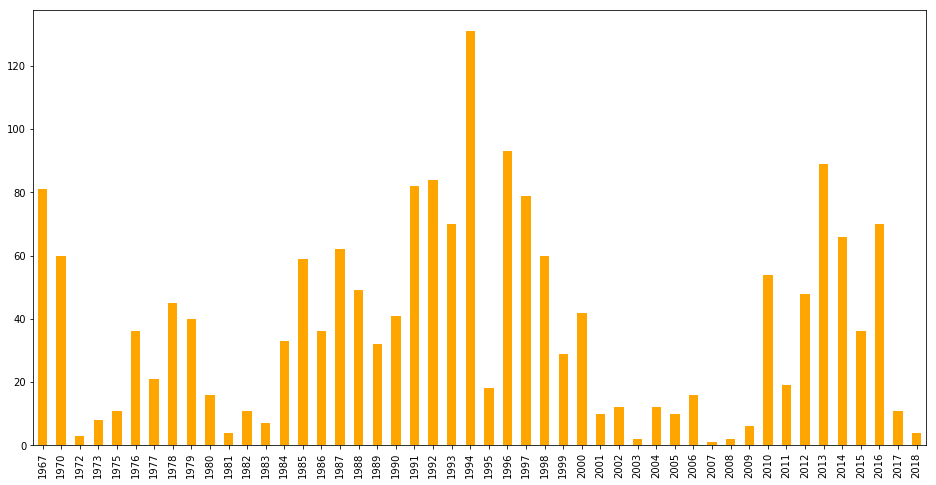

In [5]:
year_counts = df_species['listyear'].value_counts().sort_index()
plt.rcParams['figure.figsize'] = [16, 8]
year_counts.plot(kind='bar', color='orange');

Let's also look at the percentages of each current conservation status for all species

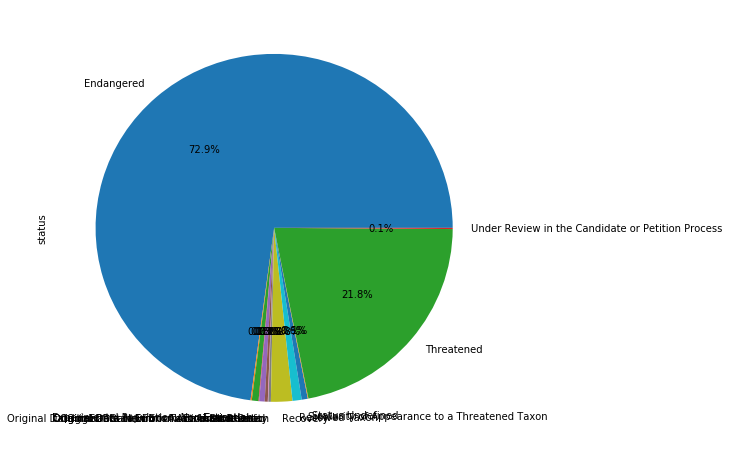

In [6]:
status_count = df_species['status'].value_counts().sort_index()
plt.rcParams['figure.figsize'] = [8, 8]
status_count.plot(kind='pie', autopct='%1.1f%%');

## Downloading petition data

One of the ways that species get listed under the ESA is by petition from the public. ECOS makes these petitions available in a nice JSON format for us.

In [7]:
url = 'https://ecos.fws.gov/ecp/report/table/petitions-received.json'
params = {'active': 'any'}
r = requests.get(url, params).json()
print('{} petition records downloaded'.format(len(r['data'])))

750 petition records downloaded


In [8]:
columnheaders = [x['title'] for x in r['metadata']['columns']]
print('Fields available in petition data:\n{}'.format("; ".join(columnheaders)))

Fields available in petition data:
Petition Title; Date Received by the FWS; Where the species is believed to or known to occur; Petitioner Name; Requested Action; Petition Finding(s); Active; Petitions Document(s)


Let's put the petition data into a DataFrame as well.

In [9]:
df_petitions = pd.DataFrame(r['data'], columns=columnheaders)
df_petitions.head()

,Petition Title,Date Received by the FWS,Where the species is believed to or known to occur,Petitioner Name,Requested Action,Petition Finding(s),Active,Petitions Document(s)
0,Petition to List the Dunes Sagebrush Lizard as...,06/01/2018,"NM, TX","[Center for Biological Diversity, Defenders of...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Dunes Sagebrus...
1,Petition to List U.S. Populations of Lake Stur...,05/23/2018,"AL, AR, GA, IA, IL, IN, KS, KY, LA, MI, MN, MO...",[Center for Biological Diversity],"[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List U.S. Populations o...
2,Petition to List the Siskiyou Mountains Salama...,03/12/2018,"CA, OR","[Cascadia Wildlands, Center for Biological Div...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Siskiyou Mount...
3,Yellowstone Bison DPS,03/05/2018,"CO, IA, MT, OK, SD, UT, WY, Canada, Mexico, Un...",[James Horsley],"[Listing: Threatened, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Yellowstone Bison Petition Volume 2...
4,PETITION TO LIST THE REFUGIO MANZANITA (ARCTOS...,11/30/2017,CA,"[Los Padres ForestWatch, The Chaparral Institu...","[Listing: Endangered, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'PETITION TO LIST THE REFUGIO MANZAN...


The `Date Received by the FWS` field contains the date that the petition was submitted. We can add a column to the petition data that contains the year component of this date.

In [10]:
df_petitions['year_received'] = df_petitions.apply(lambda x: x['Date Received by the FWS'][-4:], axis=1)
df_petitions.head()

,Petition Title,Date Received by the FWS,Where the species is believed to or known to occur,Petitioner Name,Requested Action,Petition Finding(s),Active,Petitions Document(s),year_received
0,Petition to List the Dunes Sagebrush Lizard as...,06/01/2018,"NM, TX","[Center for Biological Diversity, Defenders of...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Dunes Sagebrus...,2018
1,Petition to List U.S. Populations of Lake Stur...,05/23/2018,"AL, AR, GA, IA, IL, IN, KS, KY, LA, MI, MN, MO...",[Center for Biological Diversity],"[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List U.S. Populations o...,2018
2,Petition to List the Siskiyou Mountains Salama...,03/12/2018,"CA, OR","[Cascadia Wildlands, Center for Biological Div...","[Listing: Threatened or Endangered, APA: Desig...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Petition to List the Siskiyou Mount...,2018
3,Yellowstone Bison DPS,03/05/2018,"CO, IA, MT, OK, SD, UT, WY, Canada, Mexico, Un...",[James Horsley],"[Listing: Threatened, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'Yellowstone Bison Petition Volume 2...,2018
4,PETITION TO LIST THE REFUGIO MANZANITA (ARCTOS...,11/30/2017,CA,"[Los Padres ForestWatch, The Chaparral Institu...","[Listing: Endangered, APA: Designate Critical ...","[{'name': 'Petition findings not yet made', 'u...",Yes,[{'name': 'PETITION TO LIST THE REFUGIO MANZAN...,2017


Some petitions request that multiple species be listed under the ESA. We can find these exceptions if we look in the `Petition Title` field. We can use a function to check if the Petition Title refers to multiple species. 

In [11]:
def parseSpeciesNumber(petitionTitle):
    nspecies = re.findall('\d+', petitionTitle)
    if len(nspecies) > 0:
        return int(nspecies[0])
    else:
        return 1

In [12]:
df_petitions['n_species'] = df_petitions.apply(lambda x: parseSpeciesNumber(x['Petition Title']), axis=1)
df_petitions.at[576, 'n_species'] = 1
df_petitions.at[577, 'n_species'] = 1
df_petitions.at[582, 'n_species'] = 1
df_petitions.at[598, 'n_species'] = 1
df_petitions.at[715, 'n_species'] = 1
df_petitions.sort_values(by='n_species', ascending=False).head()

,Petition Title,Date Received by the FWS,Where the species is believed to or known to occur,Petitioner Name,Requested Action,Petition Finding(s),Active,Petitions Document(s),year_received,n_species
171,475 Southwestern species; List T/E,06/25/2007,"AL, AR, AZ, CA, CO, IL, KS, KY, LA, MT, NC, NM...","[Forest Guardians , Nicole J. Rosmarino, Conse...",[Listing: Threatened or Endangered],[{'name': '12 Month Not Warranted on 09/27/200...,Yes,[{'name': 'Petition to list 475 Southwest spec...,2007,475
101,404 Southeast aquatic species; list w/CH,04/20/2010,"AL, AR, CO, CT, DC, DE, FL, GA, IA, IL, IN, KS...","[Alabama Rivers Alliance, Center for Biologica...","[Listing: Threatened or Endangered, APA: Desig...",[{'name': '12 Month Warranted But Precluded on...,Yes,"[{'name': 'Withdrawal of Three crayfish', 'url...",2010,404
214,List 225 Candidate Species with Critical Habitat,05/11/2004,"AL, American Samoa, AR, AZ, CA, CO, DE, FL, GA...","[Barbara Kingsolver, , Biodiversity Conservati...","[Listing: Threatened or Endangered, Listing: T...",[{'name': '12 Month Not Warranted on 05/11/200...,No,[{'name': 'Petition to list 225 species- cover...,2004,225
168,206 Mountain-Prairie Region species - List as T/E,07/30/2007,"AR, AZ, CO, IA, ID, KS, MT, NE, NM, NV, OR, UT...",[Forest Guardians Nicole J. Rosmarino ],"[Listing: Threatened or Endangered, Listing: E...",[{'name': '90 Day Not Substantial on 01/06/200...,Yes,[{'name': 'Petition to list 206 Mountain-Prair...,2007,206
421,Northern goshawk (Accipiter gentilis) in the f...,09/26/1991,"AK, AL, AR, AZ, CA, FL, GA, IA, ID, IL, IN, KS...",[Dr. Robin D. Silver and 10 others ],"[Listing: Endangered, APA: Designate Critical ...",[{'name': '12 Month Not Warranted on 06/22/199...,No,"[{'name': 'Northern goshawk petition', 'url': ...",1991,100


Let's look at a bar graph to see the number of species petitioned per year.

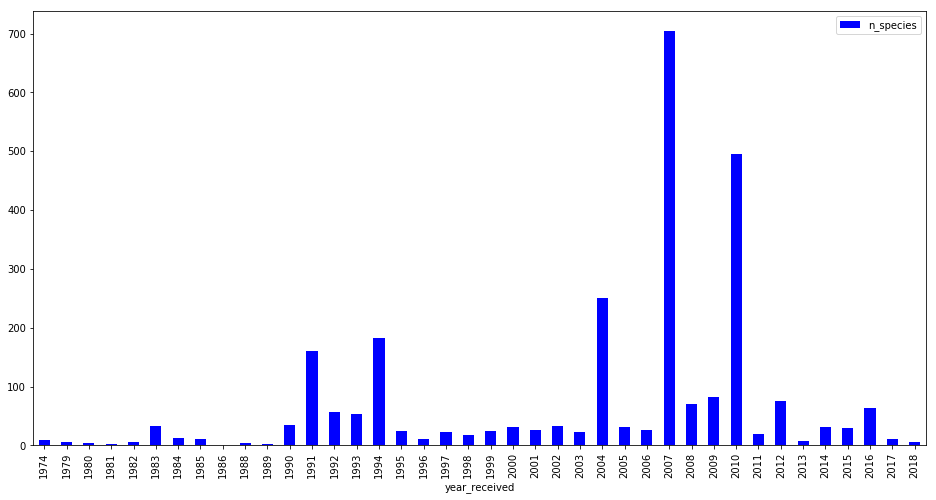

In [13]:
petitions_per_year = df_petitions[['year_received', 'n_species']].groupby('year_received').sum()
plt.rcParams['figure.figsize'] = [16, 8]
petitions_per_year.plot(kind='bar', color='blue');

## Combining species and petition data

We can merge the two DataFrames that summarize species and petitions by year.

In [14]:
df_merged = pd.concat([petitions_per_year, year_counts], axis=1, sort=True).fillna(0)
df_merged = df_merged.rename(index=str, columns={"listyear": "Species Added", "n_species": "Species Petitioned"})
df_merged.head()

,Species Petitioned,Species Added
1967,0.0,81.0
1970,0.0,60.0
1972,0.0,3.0
1973,0.0,8.0
1974,9.0,0.0


We can plot the merged DataFrame to see how the species added and the species petitioned compare each year.

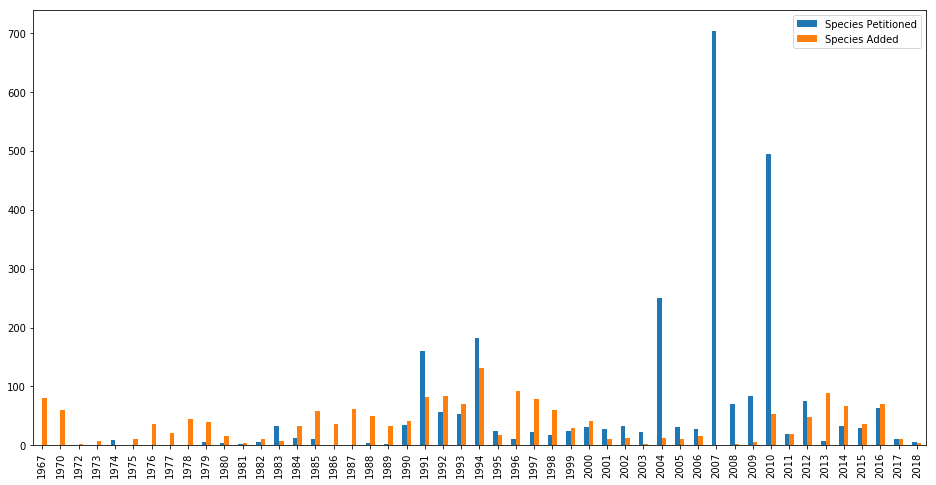

In [15]:
df_merged.plot.bar();

## Conclusions

There seem to be a couple broad trends we can draw from all our analyses.

- Looking at the numbers of petitions per year, it seems that petitioning to add species to the ESA has gotten more common over time. There are few petitions before 1990, and what seem to be a significant amount after 2000. 


- Looking at the species added per year, the data seem to be multimodal. Perhaps this could reflect the political climate of the time, and the executive branch's views on protecting endangered and threatened species?

And there are more analyses we could pursue, if we wanted to delve more deeply:

- Explore the actual `Petition Finding(s)` from the petition data. How successful are petitions?


- Do petitions or FWS scientists have a greater impact on getting species listed under the ESA?


- How do the types of species (plant, animal, invertebrate, etc.) affect the success of a petition, or the likelihood that a species will be listed?

Feel free to clone this notebook and do some of these further analyses, if you are interested in learning more!